In [13]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np

# import bokeh
# import scipy
# from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import *

In [14]:
def baselinecorr(data, mz, baseline_start, baseline_end):
    # data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # baseline_start is the end of initial ocv (in min), baseline_end is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], baseline_start)-1
    index2 = getnearpos(data['time/min'], baseline_end+200)
    
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))
    plt.plot([data['time/min'][index] , data['time/min'][index2+3]], [data[str(mz)][index],data[str(mz)][index2+3]], 'o', markersize=6, color = 'purple')

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2+3]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2+3]-fullfile['time/min'].iloc[time1])
        return m
    
    m= slope( data, mz, index, index2 )
    correct=(m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]

    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    #plt.xlim(0,200)
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()    
    
    
    return (data)



In [15]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata, iso=False):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #new as of 
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    #
    #may 2021 calibration
    m = [1.4486, 0.94558, 0.06148247455, 1.690955209, 0.7959230955]

    
    #inf_ar = 288.7462016 * 1.08*10**-9 # demsdata['36']   #as of 2/2019 # use 1.08*10**-9 instead of array if doing 18,18 o2
    if iso ==True:
        inf_ar = 278.6590323 * demsdata['36'].iloc[-20]
    else:
        inf_ar = 278.6590323 * demsdata['36']
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] =  (m[2] * demsdata['2'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['36'] = (m[0] * demsdata['36'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['46'] = (m[1] * demsdata['46'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['48'] = (m[1] * demsdata['48'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)



#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 



In [4]:
#plot galvanostatic charge
def plot_dems(chrg_ec, demi, r,  n=2, isotope = False ):
    
    end_ocv= chrg_ec[1]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi, iso= isotope)
    print('charge current (mA): '+ str(np.mean(chrg_ec[1]['I/mA'])))
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv) #chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    oxy_34 = baselinecorr( co2, 34, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)

    if isotope == True:
        co2_46 = baselinecorr( oxy_34, 46, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
        co2_48 = baselinecorr( co2_46, 48, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
        umolesdf = co2_48
    else:
        umolesdf = co2
    
    oxy_36 = baselinecorr( oxy_34, 36, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)

    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge+10] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge+10] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[end_charge+10] - np.cumsum(umolesdf['44']).iloc[start_charge]
    umoles_36 = np.cumsum(umolesdf['36']).iloc[end_charge+10]- np.cumsum(umolesdf['36']).iloc[start_charge]
    umoles_34 = np.cumsum(umolesdf['34']).iloc[end_charge+10]- np.cumsum(umolesdf['34']).iloc[start_charge]
    
    if isotope == True:
        umoles_46 = np.cumsum(umolesdf['46']).iloc[end_charge+10]- np.cumsum(umolesdf['46']).iloc[start_charge]
        umoles_48 = np.cumsum(umolesdf['48']).iloc[end_charge+10]- np.cumsum(umolesdf['48']).iloc[start_charge]
        print('46: ', str(umoles_46), ', 48: ', str(umoles_48))
    
    print ('o2: '+ str(umoles_32), 'h2: ' , str(umoles_2), 'co2: ', umoles_44, '18,18O2: ', umoles_36, '16,18O2: ', umoles_34)
    
    j1= 10
    j2= -20
    #ax2.plot(umolesdf['Capacity/mAh'][2:] , 3.6*umolesdf['I/mA'][2:]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['2']/timediff)[j1:j2] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['44']/timediff)[j1:j2] , 'o:', markersize=4, label = 'CO$_2$', color = 'xkcd:irish green')
    if isotope == True:
        
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['32']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{16,16}$O$_2$', color= 'xkcd:light blue')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['34']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{16,18}$O$_2$', color= 'm')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['36']/timediff)[j1:j2] , 'o:', markersize=4, label = '$^{18,18}$O$_2$', color = 'xkcd:cerulean')
        #ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['46']/timediff/factor)[j1:j2] , 'o:', markersize=4, label = '46')
        #ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['48']/timediff/factor)[j1:j2] , 'o:', markersize=4, label = '48', color ='xkcd:brown')
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], ((umolesdf['32']+umolesdf['34']+umolesdf['36'])/timediff)[j1:j2] , 'o:', markersize=4, label = 'total O$_2$', color='xkcd:cobalt')
        print( 'total O2 including isotopic labeling: ', str(umoles_36+umoles_32))
    else:
        ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['32']/timediff)[j1:j2] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange') #label='$^{16,16}$O$_2$'  


    ax2.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    ax2.legend(loc='upper center', bbox_to_anchor=[0.5, 1.2], ncol=4) #, title= 'm/z value')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue')
    
   # ax.set_ylim([1.6,3.0])
    #ax2.set_ylim([-0.001,0.01])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Zn$^{2+/0}$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32)*10**(6)
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return




charge current (mA): 0.5002728620958083
46:  0.04602595447577948 , 48:  0.006702871824193992
o2: 12.028365414763108 h2:  0.1587803443505494 co2:  2.902389262874796 18,18O2:  10.706892378198189 16,18O2:  0.05883924855977703
total O2 including isotopic labeling:  22.7352577929613
umoles O2: 12.028365414763108
e per mol: 6.207410697318868
charge current (mA): 0.5002805633946831
46:  0.03893064538052975 , 48:  0.0036642683000866223
o2: 15.843194968869845 h2:  -0.38138993263692494 co2:  3.412323648432922 18,18O2:  4.069287407658256 16,18O2:  0.07766196970571645
total O2 including isotopic labeling:  19.9124823765281
umoles O2: 15.843194968869845
e per mol: 4.712785367821018


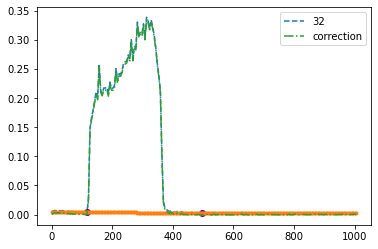

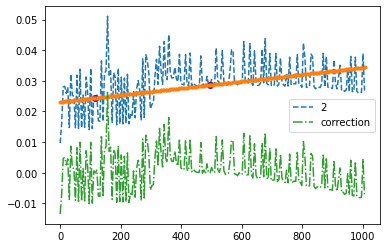

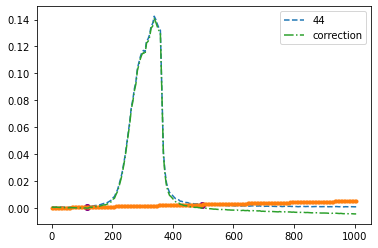

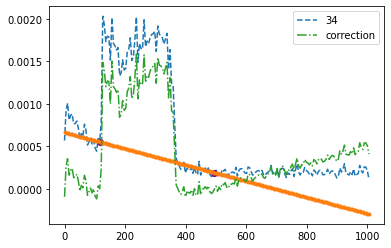

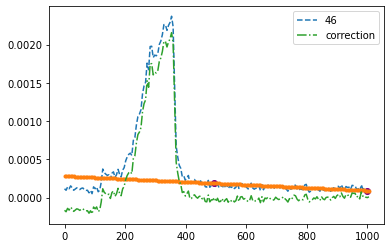

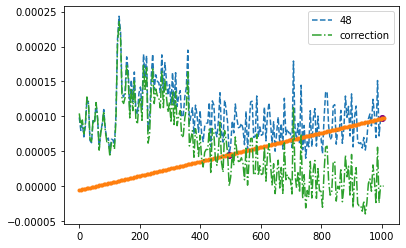

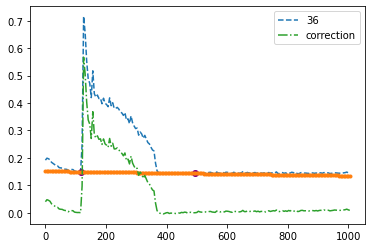

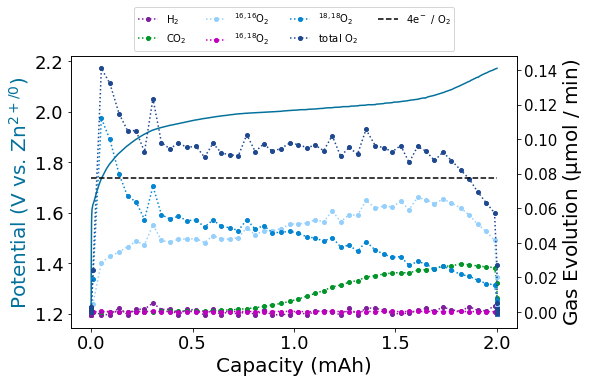

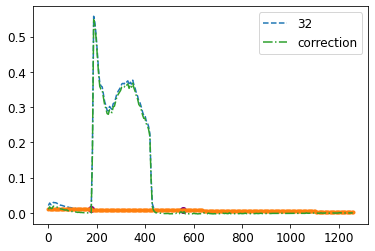

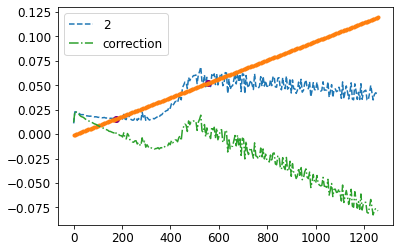

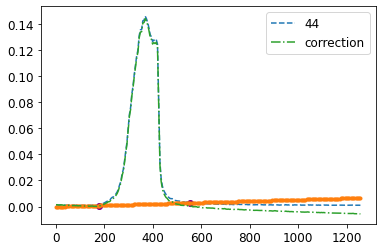

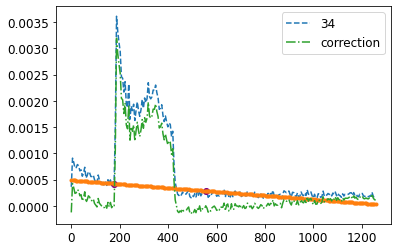

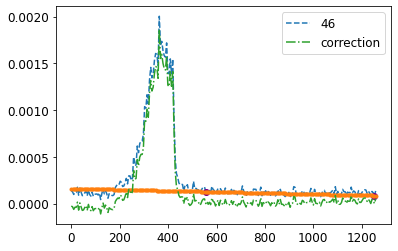

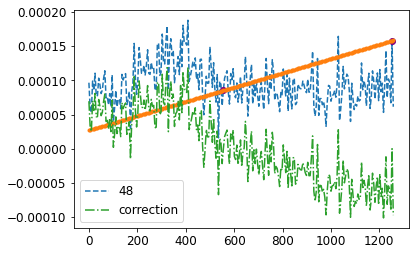

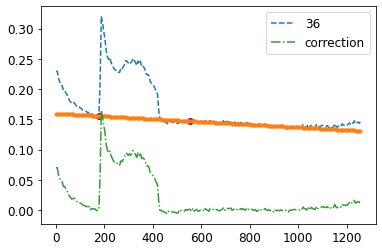

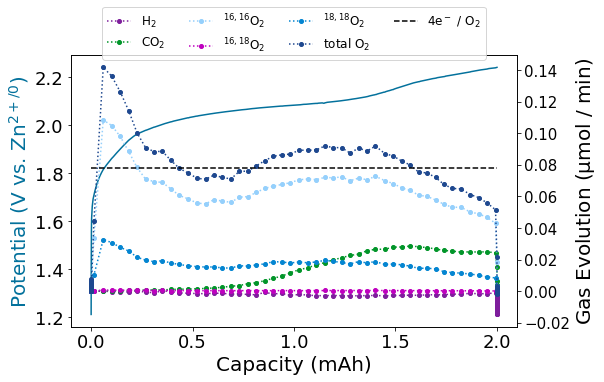

In [5]:
longer_isotop_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_halfdisch18O2_2mAh_dems/211101_Zn_halfdisch18O2_2mAh_dems_chrg_2021-11-01_16.32_57.txt')
longer_isotop_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_halfdisch18O2_2mAh_dems/')

plot_dems(longer_isotop_fold, longer_isotop_dems, r=1, n=4, isotope=True)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211101_Zn_halfdisch18O2_2mAh_dems/211101_Zn_halfdisch18O2_2mAh_dems_chrg.png', transparent = True, dpi=600, bbox_inches='tight')


mixed_isotopes_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211118_Zn_mixed-isotopes_O2_dems/211118_Zn_mixed-isotopes_O2_dems_chrg_2021-11-18_22.54_52.txt')
mixed_isotopes_f = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211118_Zn_mixed-isotopes_O2_dems/')

plot_dems(mixed_isotopes_f, mixed_isotopes_dems, r=1, n=4, isotope=True)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211118_Zn_mixed-isotopes_O2_dems/211118_Zn_mixedO2isotopes_dems.png', transparent = True, dpi=600, bbox_inches='tight')




charge current (mA): 0.5002841568604651
o2: 0.18913203601259249 h2:  3.1677976681232733 co2:  1.2935953171521362 18,18O2:  -0.03271457354181295 16,18O2:  0.0007635101726824762
umoles O2: 0.18913203601259249
e per mol: 197.39342994712115
charge current (mA): 0.5002789797286822
o2: 6.709143280924524 h2:  0.08250928406690412 co2:  1.5570820154625522 18,18O2:  -0.20452495364903692 16,18O2:  0.04600183481768398
umoles O2: 6.709143280924524
e per mol: 5.564537291529177


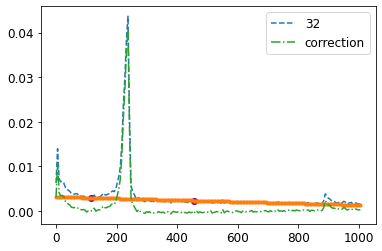

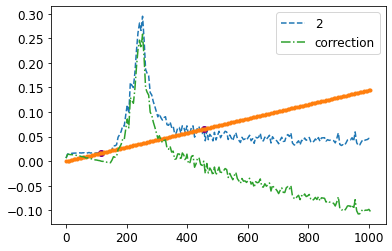

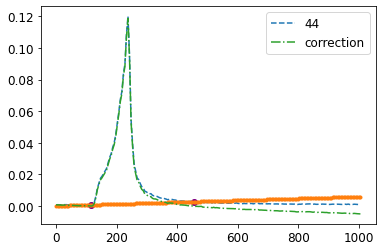

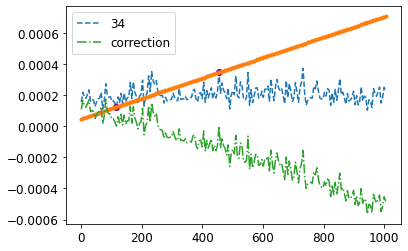

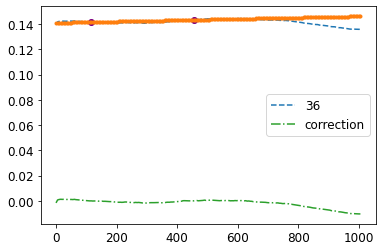

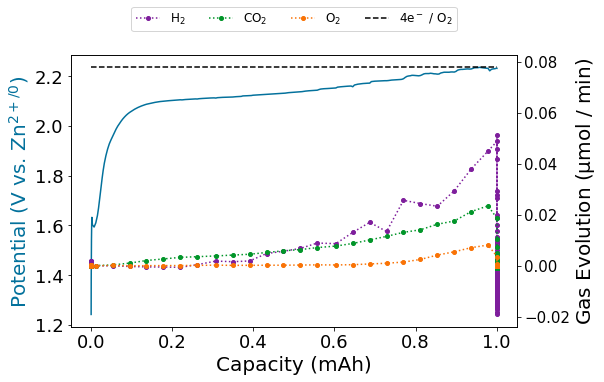

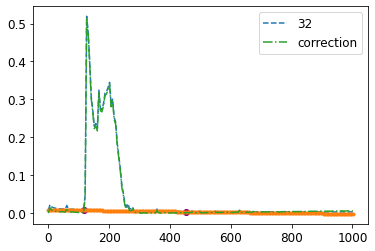

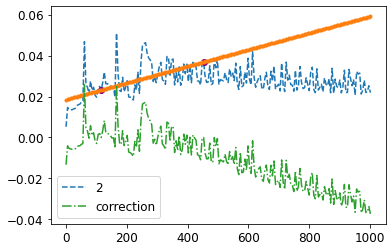

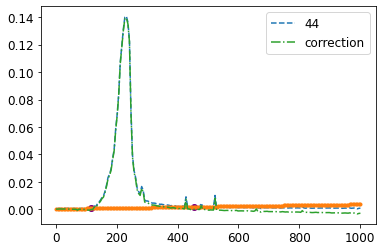

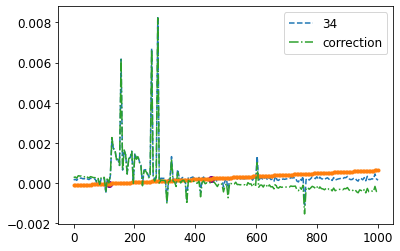

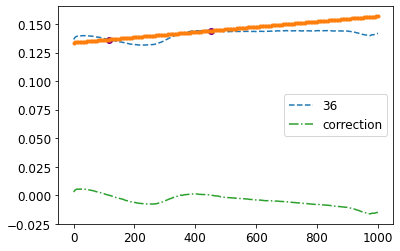

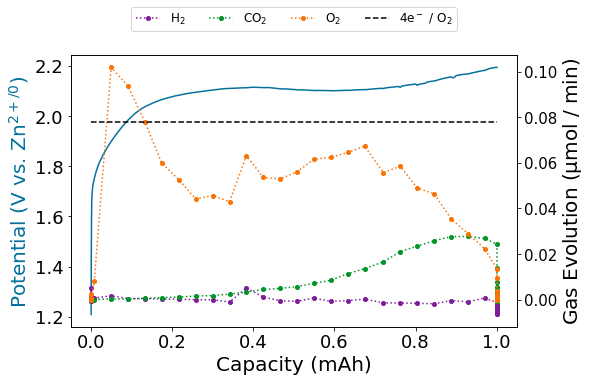

In [12]:
mno2_dems_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211123_Zn_O2_MnO2-XC72_cycle_dems/')
mno2_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211123_Zn_O2_MnO2-XC72_cycle_dems/211123_Zn_O2_MnO2-XC72_cycle_dems_chrg_2021-11-23_22.48_12.txt')

plot_dems(mno2_dems_fold, mno2_dems, r=1, n=4)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211123_Zn_O2_MnO2-XC72_cycle_dems/211123_Zn_MnO2-XC72_cycle_dems.png', transparent = True, dpi=600, bbox_inches='tight')



tio2_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211130_Zn_O2_TiO2-XC72_cycle_dems/211130_Zn_O2_TiO2-XC72_cycle_dems_chrg_2021-11-30_12.02_41.txt')
tio2_ec = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211130_Zn_O2_TiO2-XC72_cycle_dems/')

plot_dems(tio2_ec, tio2_dems, r=1, n=4)


#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/211130_Zn_O2_TiO2-XC72_cycle_dems/211130_Zn_O2_TiO2-XC72_cycle_dems.png', transparent = True, dpi=600, bbox_inches='tight')


